 --- 
# UCI - Default from Credit Card Clients
---

# Dataset presentation

This dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

It can be found here:
https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

## Variables
There are 25 variables:

* ID: ID of each client
* LIMIT_BAL: Amount of given credit in NT dollars (includes individual and family/supplementary credit
* SEX: Gender (1=male, 2=female)
* EDUCATION: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown)
* MARRIAGE: Marital status (1=married, 2=single, 3=others)
* AGE: Age in years
* PAY_0: Repayment status in September, 2005 (-1=pay duly, 1=payment delay for one month, 2=payment delay for two months, ... 8=payment delay for eight months, 9=payment delay for nine months and above)
* PAY_2: Repayment status in August, 2005 (scale same as above)
* PAY_3: Repayment status in July, 2005 (scale same as above)
* PAY_4: Repayment status in June, 2005 (scale same as above)
* PAY_5: Repayment status in May, 2005 (scale same as above)
* PAY_6: Repayment status in April, 2005 (scale same as above)
* BILL_AMT1: Amount of bill statement in September, 2005 (NT dollar)
* BILL_AMT2: Amount of bill statement in August, 2005 (NT dollar)
* BILL_AMT3: Amount of bill statement in July, 2005 (NT dollar)
* BILL_AMT4: Amount of bill statement in June, 2005 (NT dollar)
* BILL_AMT5: Amount of bill statement in May, 2005 (NT dollar)
* BILL_AMT6: Amount of bill statement in April, 2005 (NT dollar)
* PAY_AMT1: Amount of previous payment in September, 2005 (NT dollar)
* PAY_AMT2: Amount of previous payment in August, 2005 (NT dollar)
* PAY_AMT3: Amount of previous payment in July, 2005 (NT dollar)
* PAY_AMT4: Amount of previous payment in June, 2005 (NT dollar)
* PAY_AMT5: Amount of previous payment in May, 2005 (NT dollar)
* PAY_AMT6: Amount of previous payment in April, 2005 (NT dollar)
* default.payment.next.month: Default payment (1=yes, 0=no)


In [31]:
%load_ext autoreload
%autoreload 2

In [5]:
    # This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path


# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

"""
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
"""

# Any results you write to the current directory are saved as output.

"\nimport os\nfor dirname, _, filenames in os.walk('/kaggle/input'):\nfor filename in filenames:\n    print(os.path.join(dirname, filename))\n"

# Useful imports

## Packages

In [7]:
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
pd.set_option('display.max_columns', 999)

In [9]:
sns.set_style("darkgrid")

## Data Preparation imports

In [10]:
from sklearn.preprocessing import StandardScaler

## Model imports

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

## Metrics imports

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

# Defining our functions for importing Data

In [13]:
path = 'UCI_Credit_Card.csv'

In [24]:
def load_raw_data(path):
    root = Path('.')
    df = pd.read_csv(root / path)
    return df

In [30]:
def load_data(path):
    df = load_raw_data(path)
    
    # Dropping ID column
    df = df.drop(columns='ID')
    
    # Renaming a few misnamed columns
    df = df.rename(columns = {'PAY_0':'PAY_1', 
                          'default.payment.next.month': 'default',
                         'SEX':'GENDER'})
    # Lowercase our column names
    colonnes = list(df.columns)
    renaming_dict = {}
    new_colonnes = []
    for colonne in colonnes:
        new_colonne = colonne.lower()
        renaming_dict[colonne] = new_colonne
        new_colonnes.append(new_colonne)
    df = df.rename(columns=renaming_dict)
    
    # Cleaning our mislabelled Data
    # Cleaning our mislabelled pay_n data
    pay_columns = ['pay_'+str(i) for i in range(1,7)]
    for pay_col in pay_columns:
        df.loc[df[pay_col] >0, pay_col] = 1
        df.loc[df[pay_col] <= 0, pay_col] = 0
    # Cleaning our mislabelled education data
    df.loc[df['education'].isin([0,4,5,6]), 'education'] = 4
    # Cleaning our mislabelled education data
    df.loc[df['marriage'].isin([0,3,4]), 'marriage'] = 3

    
    # Defining our (X, y)
    X = df.drop(['default'], axis=1)
    y = df[['default']]
    
    return (X,y)

In [29]:
df = load_raw_data(path)
X, y = load_data(path)


# Feature Engineering

## Age Binning

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C4858658D0>]],
      dtype=object)

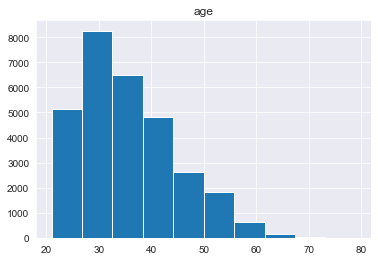

In [32]:
X[['age']].hist()

In [34]:
X[['age']].describe()

,age
count,30000.000000
mean,35.485500
std,9.217904
min,21.000000
25%,28.000000
50%,34.000000
75%,41.000000
max,79.000000


In [37]:
bin_names = []
for i in range(2,8):
    bin_names.append(str(i)+'0s')
X['age_bin'] = pd.cut(X['age'], 6, labels=bin_names)

In [38]:
X['age_bin'].value_counts()

20s    11013
30s    10713
40s     6005
50s     1930
60s      314
70s       25
Name: age_bin, dtype: int64

Our last category '70s' is not populated enough, let's merge it with the '60s', so that it doesn't skew the results too much because of a few outliers

In [42]:
X[['age_bin']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 1 columns):
age_bin    30000 non-null category
dtypes: category(1)
memory usage: 29.6 KB


In [45]:
X['age_bin'] = X['age_bin'].cat.add_categories('60+')

In [46]:

X.loc[(X['age_bin']=='60s') | (X['age_bin']=='70s'), 'age_bin'] = '60+'

In [47]:
X['age_bin'].value_counts()

20s    11013
30s    10713
40s     6005
50s     1930
60+      339
70s        0
60s        0
Name: age_bin, dtype: int64

In [48]:
X['age_bin'] = X['age_bin'].cat.remove_unused_categories()

In [49]:
X['age_bin'].value_counts()

20s    11013
30s    10713
40s     6005
50s     1930
60+      339
Name: age_bin, dtype: int64

## New category Gender x Marriage

## Let's add a linear bill_amt0 prediction to our features

# Training our models